# **MIMIC-ED Activity Sequence Analysis**

This notebook explores patient activity sequences in the MIMIC-IV-ED dataset. It includes steps for cleaning and preparing the data, interactively examining patient records, and analyzing patterns in clinical workflows. Specifically, it covers:

- Data deduplication to ensure unique activity records

- Interactive EHR lookup widget for exploring patient stays and events

- Descriptive analysis of stay and activity distributions

- Transition analysis, including transition matrices and probabilities between consecutive activities

In [1]:
import duckdb
import pathlib as pl
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import plotly.graph_objects as go

# automatically locates the project root and set up relative paths to the data folder
# this makes the notebook reproducible for anyone who clones the repo
ROOT = pl.Path.cwd().parent
DATA = ROOT / "MIMIC_ED"
RAW = DATA / "raw" / "mimicel.csv"

# relative paths
RAW = pl.Path("../../MIMIC_ED/raw/mimicel.csv")
CLEAN = pl.Path("../../MIMIC_ED/cleaned/mimicel_clean.csv")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 2000)        # Increase total display width

# Q/A from last meeting:

## What is the time frame MIMIC IV spans?
> Mimic IV spans 2008 - 2022

## Why were there 2x Discharge logs than Enter logs?
> `Enter the ED` and `Discharge from the ED` differ because people can be discharged with multiple diagnoses, and each is recorded as a 
separate log in the the table. Some `stay_id` will have as much as 5+ rows correlated with discharge


# Focus on activity sequencing
## Look at the order people do steps in. Is it the same or different for everyone?
Goal: Create a visual diagram showing the order of activities for ED patients

**Sampled patient subset**: I randomly sampled 5% of unique subject_ids and then selected all rows (activities) associated with those patients.
Because some patients have more or fewer recorded events than others, the resulting dataset represents approximately 4.58% of the total rows in the original data.

In [2]:
SAMPLE_SEED = 42
con = duckdb.connect()

df_sample = con.execute(f"""
    WITH patients AS (
        SELECT DISTINCT subject_id
        FROM read_csv_auto('{RAW}')
    ),
    sampled AS (
        SELECT subject_id
        FROM patients
        USING SAMPLE 5 PERCENT (SYSTEM, {SAMPLE_SEED})
    )
    SELECT *
    FROM read_csv_auto('{RAW}')
    WHERE subject_id IN (SELECT subject_id FROM sampled)
""").df()
# df_original = con.execute(f"SELECT * FROM read_csv_auto('{RAW}')").df()
df = df_sample.copy()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
original_len = 7568824 #pulled from previous aggregate in 01_notebook
print(f"Original dataset: {original_len} rows")
print(f"After sampling 5% of patients (keeping all their activity): {df.shape[0]} rows")
print(f"→ This corresponds to {df.shape[0]/original_len * 100:.2f}% of the total data")

Original dataset: 7568824 rows
After sampling 5% of patients (keeping all their activity): 349255 rows
→ This corresponds to 4.61% of the total data


In [4]:
num_patients = df['subject_id'].nunique()


print(f'We are now looking at {num_patients} patients (5% sample of patients from original dataframe)')

We are now looking at 14336 patients (5% sample of patients from original dataframe)


In [5]:
# print("Columns (n={}):".format(len(df.columns)))
# print(list(df.columns))

print("\nActivity vocabulary (top):")
vc = df["activity"].value_counts(dropna=False)
display(vc.to_frame("count"))



Activity vocabulary (top):


,count
activity,
Medicine reconciliation,117033
Vital sign check,72455
Medicine dispensations,69897
Discharge from the ED,45672
Enter the ED,22099
Triage in the ED,22099


> ^^ `Enter the ED` and `Discharge from the ED` differ because people can be discharged with multiple diagnoses, and each is recorded as a 
separate log in the the table. Some `stay_id` will have as much as 5+ rows correlated with discharge

Below are examples of stay_id that have multiple instances of 'Discharge from the ED' activity

In [6]:
grouped_activity_df = df.groupby(['stay_id', 'timestamps', 'activity']).count().reset_index()
    
grouped_activity_df[grouped_activity_df['activity'] == 'Discharge from the ED'].rename(columns = {'subject_id': 'instances'})[['stay_id', 'timestamps', 'activity', 'instances']].head(3)

,stay_id,timestamps,activity,instances
5,30073413,2143-01-26 22:45:00,Discharge from the ED,2
19,30148935,2118-08-24 10:21:00,Discharge from the ED,2
28,30148985,2159-06-18 02:56:00,Discharge from the ED,1


For the purpose of counting the number of steps in a patient’s stay, we will assume that each patient enters and exits the Emergency Department only once. However, we will retain multiple occurrences of intermediate activities (e.g., medication reconciliation, vital sign checks) within the stay, as these repeated steps represent distinct clinical actions that should be counted.

## Deduplicating Rows

To ensure that each recorded clinical action is counted only once per patient stay, we defined a log (or a row) as unique if the combination of the following fields is distinct:

`subject_id` (identifies the patient)

`stay_id` (identifies the hospital stay)

`timestamps` (the exact time of the activity)

`activity` (type of clinical action, e.g., “Vital sign check” or “Medicine dispensation”)

Duplicate rows with identical values across these fields are removed so that each step appears only once. Some rows are repeated in the raw data because:

1. The same action or medication may be recorded multiple times under different reference codes. Or,

2. For activities that involve multiple medications or diagnoses (e.g., a single “Medicine dispensation” with several drugs), multiple rows exist for each item.

To address this, we aggregate the `name` and `icd_title` columns into lists for these multi-item steps, preserving all relevant information while representing the step as a single row. This approach ensures that each activity step is unique per patient stay, while retaining the full set of associated medications or diagnoses.

In [7]:
# Define the columns that make a log "unique"
unique_cols = ['subject_id', 'stay_id', 'timestamps', 'activity',]

# Drop duplicates based on these columns, keep the first occurrence
df_deduped = df.drop_duplicates(subset=unique_cols, keep='first')

# Optional: check how many rows were removed
print(f"Original rows: {len(df)}")
print(f"Rows after deduplication: {len(df_deduped)}")


# Group by the unique step columns and collect all 'name's into a list
df_compressed = (
    df
    .groupby(unique_cols, as_index=False)
    .agg({'name': list, 'icd_title': list})
)

# Merge the aggregated columns into df_deduped
df_deduped = df_deduped.drop(columns=['name', 'icd_title'], errors='ignore')  # remove old columns
df_deduped = df_deduped.merge(
    df_compressed,
    on = unique_cols,
    how='left'
)

df_deduped.head()

Original rows: 349255
Rows after deduplication: 206355


,stay_id,subject_id,hadm_id,timestamps,activity,gender,race,arrival_transport,disposition,seq_num,icd_code,icd_version,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,rhythm,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn,name,icd_title
0,30295088,11435281,<NA>,2151-08-29 13:32:00,Enter the ED,M,BLACK/AFRICAN AMERICAN,AMBULANCE,None,<NA>,None,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None]
1,30295088,11435281,<NA>,2151-08-29 13:32:01,Triage in the ED,None,None,None,None,<NA>,None,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,10,2.0,WITHDRAWEL,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None]
2,30295088,11435281,<NA>,2151-08-29 13:46:00,Vital sign check,None,None,None,None,<NA>,None,<NA>,98.0,79.0,19.0,99.0,149.0,99.0,10,NaN,None,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None]
3,30295088,11435281,<NA>,2151-08-29 14:10:00,Medicine dispensations,None,None,None,None,<NA>,None,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,015869,None,<NA>,None,None,1,1,"[Ondansetron, Ondansetron]","[None, None]"
4,30295088,11435281,<NA>,2151-08-29 14:34:00,Vital sign check,None,None,None,None,<NA>,None,<NA>,NaN,79.0,NaN,NaN,135.0,85.0,10,NaN,None,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None]


### Let's define a simple look up function based on `subject_id` and `stay_id`

In [8]:
def lookup_patient(df = df_deduped,
                   subject_id = None, 
                   stay_id = None, 
                  ):
    '''
    Looks up logs for the given subject_id and/or stay_id
    
    '''
    if subject_id == None:
        output = df[(df['stay_id'] == stay_id)].sort_values(by = 'timestamps', ascending = True)
    elif stay_id == None:
        output = df[(df['subject_id'] == subject_id)].sort_values(by = 'timestamps', ascending = True)
    else:
        output = df[(df['stay_id'] == stay_id) & (df['subject_id'] == subject_id)].sort_values(by = 'timestamps', ascending = True)
    
    return output

In [9]:
def lookup_patient_journey(df = df_deduped, subject_id = None, stay_id=None):
    '''
    Takes in stay_id, subject_id, or both, and outputs timestamps and all activities for the patient/stay_id combination.

    Or can output all activities for all stays for one subject_id
    '''
    df_patient = None
    if subject_id == None:
        df_patient = df[df['stay_id']==stay_id]

    elif stay_id == None:
        df_patient = df[df['subject_id']==subject_id]
        
    else:
        df_patient = df[(df['stay_id']==stay_id) &( df['subject_id']==subject_id)]

        
    df_patient = df_patient.sort_values('timestamps')
    return df_patient[['timestamps', 'activity']]


# Distribution of Activities Across Stays

First, we want to visualize the distribution of average # of steps that happen per `stay_id`. We can see that the average stay in the ED has about 9.3 steps administered to the patient, with a median of 8 activities.

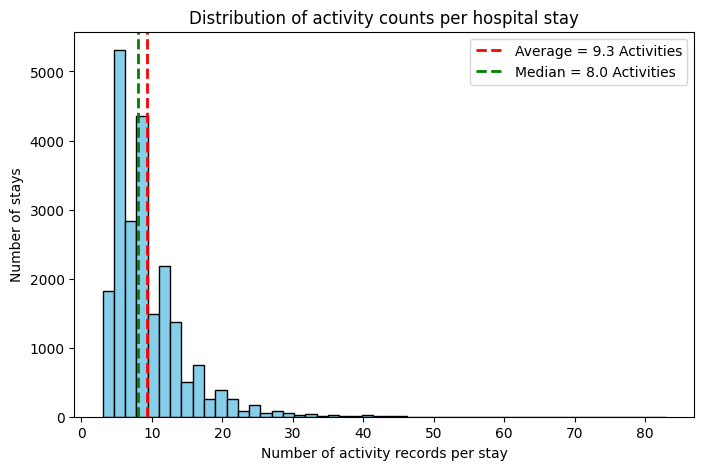

In [10]:
# Count activities per stay
activity_counts = df_deduped.groupby(['subject_id', 'stay_id']).size()
# print(activity_counts)
mean_val = activity_counts.mean()
median_val = activity_counts.median()

plt.figure(figsize=(8, 5),)
plt.hist(activity_counts, bins=50, color='skyblue', edgecolor='black', rwidth= 1)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Average = {mean_val:.1f} Activities')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median = {median_val:.1f} Activities')

plt.xlabel("Number of activity records per stay")
plt.ylabel("Number of stays")
plt.title("Distribution of activity counts per hospital stay")
plt.legend()
plt.show()

# top_stays = activity_counts.sort_values(ascending=False).head(20)
# print(top_stays)
# top_stays.plot(kind='bar', figsize=(10, 5))
# plt.ylabel("Activity count")
# plt.title("Top 20 stays with the most activity records")
# plt.show()


When looking at the number of steps per activity, vital sign check is repeated the most across all stays, with a median of happening 3 times per stay.

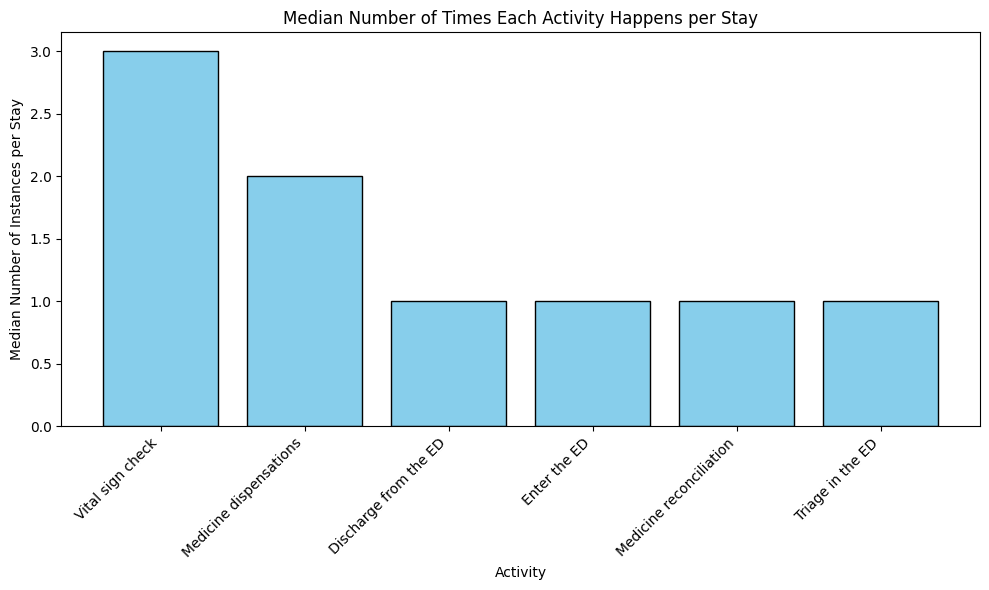

In [11]:
# average number of times each activity happens per stay
step_counts = df_deduped.groupby(['stay_id', 'activity']).size()
avg_per_activity = step_counts.groupby('activity').median()


avg_num_instances = pd.DataFrame(avg_per_activity.sort_values(ascending=False)).rename(columns = {0: 'Avg Number of Instances'})
    

plt.figure(figsize=(10, 6))
plt.bar(avg_num_instances.index, avg_num_instances['Avg Number of Instances'], color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')  # rotate x labels for readability
plt.xlabel("Activity")
plt.ylabel("Median Number of Instances per Stay")
plt.title("Median Number of Times Each Activity Happens per Stay")
plt.tight_layout()
plt.show()


The most common sequence of events across this patient sample was `('Enter the ED', 'Triage in the ED', 'Vital sign check', 'Discharge from the ED')`

In [12]:
activity_sequences = (
    df_deduped.groupby('stay_id')['activity']
    .apply(list)  # list of activities per stay
)

from collections import Counter

sequence_counts = Counter(tuple(seq) for seq in activity_sequences)

# Get the most common sequence(s)
most_common_sequence, count = sequence_counts.most_common(1)[0]

print("Most common sequence:", most_common_sequence)
print("Occurred in", count, "stays")

Most common sequence: ('Enter the ED', 'Triage in the ED', 'Vital sign check', 'Discharge from the ED')
Occurred in 796 stays


# Interactive EHR lookup

To interact with the widget, please launch this repo locally, and have your data environment set up according the the ReadMe/notebook01

This widget allows exploration of a patient’s activities during a specific hospital stay. Users can select a patient (subject_id) and a stay (stay_id) from dropdown menus, and the code displays a table of all activities with timestamps, a summary count per activity, and the total duration of the stay. A dynamic timeline is plotted as a “stair-step” diagram, where each activity is represented as a dot along the time axis, connected by lines to show the sequence of events.

In [13]:
subject_ids = df_deduped['subject_id'].unique()
patient_dropdown = widgets.Dropdown(
    options=subject_ids,
    description='Patient ID:',
    value=subject_ids[0],
    disabled=False,
)

# Dropdown for stay ID, will update based on selected patient
stay_dropdown = widgets.Dropdown(
    options=[],
    description='Stay ID:',
    disabled=False,
)

# Output area
output = widgets.Output()

# -------------------------------
# Functions

def update_stay_options(change):
    """Update stay options when patient changes."""
    patient_id = change['new']
    stays = df_deduped[df_deduped['subject_id']==patient_id]['stay_id'].unique()
    stay_dropdown.options = stays
    stay_dropdown.value = stays[0]

def display_journey(change):
    """Display activities for selected patient/stay."""
    output.clear_output()
    patient_id = patient_dropdown.value
    stay_id = stay_dropdown.value
    
    df_patient = df_deduped[(df_deduped['subject_id']==patient_id) & 
                            (df_deduped['stay_id']==stay_id)].sort_values('timestamps')
    activities = list(df_patient['activity'].values)

    times = list(df_patient['timestamps'].values)
    summary = pd.DataFrame(df_patient.value_counts('activity'))
    
    enter_time = df_patient.loc[df_patient['activity'] == 'Enter the ED', 'timestamps'].iloc[0]
    discharge_time = df_patient.loc[df_patient['activity'] == 'Discharge from the ED', 'timestamps'].iloc[0]
    
    # Calculate duration
    duration = discharge_time - enter_time
    disposition = df_patient[df_patient['activity'] == 'Discharge from the ED']['disposition'].iloc[0]
    

    with output:
        if df_patient.empty:
            print("No data for this patient/stay.")
            return

        print('\n')
        
        print(f"Patient ID: {patient_id}, Stay ID: {stay_id}")
        df1_html = df_patient[['timestamps', 'activity']].to_html()
        df2_html = summary.to_html()
        
        display(HTML(f"""
        <div style="display: flex; gap: 50px;">
            <div>{df1_html}</div>
            <div>{df2_html}</div>
        </div>
        """))


        print("Duration:", duration)
        print(f"Disposition: {disposition}")

        # plot the timeline
        
        fig = go.Figure()
        
        # Add dots
        # Assign stair-step y-positions: first activity at top, last at bottom
        y_positions = list(range(len(activities), 0, -1))
        
        fig = go.Figure()
        
        # Plot dots at stair-step y-positions
        fig.add_trace(go.Scatter(
            x=times,
            y=y_positions,
            mode='markers+text',
            marker=dict(size=15, color='skyblue'),
            text=activities,
            textposition="middle right",
            showlegend = False
            
        ))
        
        # Optional: connect dots with lines to show flow
        fig.add_trace(go.Scatter(
            x=times,
            y=y_positions,
            mode='lines',
            line=dict(color='black'),
            showlegend=False
        ))
        
        # Layout
        fig.update_layout(
            height=400 + 20*len(activities),  # dynamically adjust height
            width=1000 + 20*len(times),
            title=f"ED Activity Timeline for Patient ID {patient_id}, Stay ID {stay_id}",
            yaxis=dict(visible=False),  # hide y-axis, because we use it just for spacing
            xaxis_title="Time",
        )
        x_min = min(times)
        x_max = max(times)
        x_minrange_padding = (x_max - x_min) * 0.05  # 5% extra on left
        x_max_range_padding = (x_max - x_min) * 0.25  # 25% extra on right

        fig.update_xaxes(range=[x_min - x_minrange_padding, x_max + x_max_range_padding])

        fig.show()

        
# -------------------------------
# Link widgets
patient_dropdown.observe(update_stay_options, names='value')
stay_dropdown.observe(display_journey, names='value')

# Initialize stay options and display
update_stay_options({'new': patient_dropdown.value})
display_journey(None)

# -------------------------------
# Display widgets and output
display(patient_dropdown, stay_dropdown, output)

Dropdown(description='Patient ID:', options=(11435281, 16228540, 14282803, 12307488, 10388908, 13802001, 10144…

Dropdown(description='Stay ID:', options=(30295088, 31036530, 35367533), value=30295088)

Output()

# Transition Matrix

Lets now look at how often each activity transitions to another. First we will create a new column `next_activity` that shows what the next consecutive step will be. We'll also pull the timestamp for the next activity, labeled `next_activity_time`. This way, we're able to compute the inter-activity time

In [14]:
# Ensure it's sorted correctly by patient, stay, and time
df_with_next_step = df_deduped.sort_values(['subject_id', 'stay_id', 'timestamps'])

# when timestamps are overlapped, the rank ensures that the most logical workflow is preserved
# ensures that 'entering the ED' is always first, even if the timestamp is the same as the next activity
# intermediate steps can be determined by their original order in the df
# discharge activity set to 2 to make sure  it's always last, even if it matches the time stamp of the previous step
activity_priority = {
    "Enter the ED": 0,
    "Triage in the ED": 1,
    "Vital sign check": 1,
    "Medicine reconciliation": 1,
    "Medicine dispensations": 1,
    "Discharge from the ED": 2
}

df_with_next_step['activity_rank'] = df_with_next_step['activity'].map(activity_priority)

df_with_next_step = df_with_next_step.sort_values(
    ['stay_id', 'timestamps', 'activity_rank',  ])



df_with_next_step['next_activity'] = df_with_next_step.groupby('stay_id')['activity'].shift(-1)
df_with_next_step['next_activity_time'] = df_with_next_step.groupby('stay_id')['timestamps'].shift(-1)
df_with_next_step['inter_activity_time'] = df_with_next_step['next_activity_time'] - df_with_next_step['timestamps']

print(f"Rows preserved? {df_deduped.shape[0]} == {df_with_next_step.shape[0]} == True")



df_with_next_step.head(3)

Rows preserved? 206355 == 206355 == True


,stay_id,subject_id,hadm_id,timestamps,activity,gender,race,arrival_transport,disposition,seq_num,icd_code,icd_version,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,rhythm,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn,name,icd_title,activity_rank,next_activity,next_activity_time,inter_activity_time
163792,30073413,10232160,26884134,2143-01-26 13:30:00,Enter the ED,F,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,AMBULANCE,None,<NA>,None,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None],0,Triage in the ED,2143-01-26 13:30:01,0 days 00:00:01
163793,30073413,10232160,26884134,2143-01-26 13:30:01,Triage in the ED,None,None,None,None,<NA>,None,<NA>,98.2,61.0,16.0,100.0,110.0,64.0,0,2.0,SI,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None],1,Vital sign check,2143-01-26 13:32:00,0 days 00:01:59
163794,30073413,10232160,26884134,2143-01-26 13:32:00,Vital sign check,None,None,None,None,<NA>,None,<NA>,98.2,61.0,16.0,100.0,110.0,64.0,0,NaN,None,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None],1,Vital sign check,2143-01-26 18:21:00,0 days 04:49:00


In [15]:
transition_counts = (
    df_with_next_step.dropna(subset=['next_activity']) # Discharge is never followed up with another activity, so we will drop these rows
      .groupby(['activity', 'next_activity'])
      .size()
      .reset_index(name='count')
)

transition_matrix = transition_counts.pivot(
    index='activity', columns='next_activity', values='count'
).fillna(0).astype(int)


activity_order = [
    "Enter the ED",
    "Triage in the ED",
    "Vital sign check",
    "Medicine reconciliation",
    "Medicine dispensations",
]
next_activity_order = [
    "Triage in the ED",
    "Vital sign check",
    "Medicine reconciliation",
    "Medicine dispensations",
    "Discharge from the ED"
]
transition_matrix = transition_matrix.loc[activity_order, next_activity_order]
transition_matrix

next_activity,Triage in the ED,Vital sign check,Medicine reconciliation,Medicine dispensations,Discharge from the ED
activity,,,,,
Enter the ED,18013,4079,0,7,0
Triage in the ED,0,11434,6175,3831,659
Vital sign check,4080,27217,6997,17004,17115
Medicine reconciliation,0,8872,12015,5569,939
Medicine dispensations,6,20811,2208,13782,3386


In [16]:
transition_probs = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
# transition_probs = transition_probs.loc[activity_order, next_activity_order]
transition_probs

next_activity,Triage in the ED,Vital sign check,Medicine reconciliation,Medicine dispensations,Discharge from the ED
activity,,,,,
Enter the ED,0.815105,0.184578,0.000000,0.000317,0.000000
Triage in the ED,0.000000,0.517399,0.279424,0.173356,0.029820
Vital sign check,0.056343,0.375858,0.096626,0.234820,0.236353
Medicine reconciliation,0.000000,0.323855,0.438584,0.203285,0.034276
Medicine dispensations,0.000149,0.517777,0.054935,0.342896,0.084244


This matrix illustrates the likelihood of each clinical activity being immediately followed by another during a patient’s stay in the Emergency Department (ED).
Each cell shows the conditional probability that a “Next Activity” occurs given a “Current Activity” — effectively capturing the behavioral flow of care.


Key Insights:
- High probabilities along the diagonal (e.g., Triage → Vital Sign Check, 0.51 indicate that certain activities often repeat or persist, reflecting multi-step or ongoing processes (e.g., repeated triage assessments).

- The transition from Enter the ED → Triage in the ED (0.81) suggests that most patients are triaged soon after entry, but not always immediately

- Medicine reconciliation → Medicine reconciliation (0.45) and Medicine dispensations → Vital sign check (0.31) indicate areas where documentation or follow-up cycles are common.


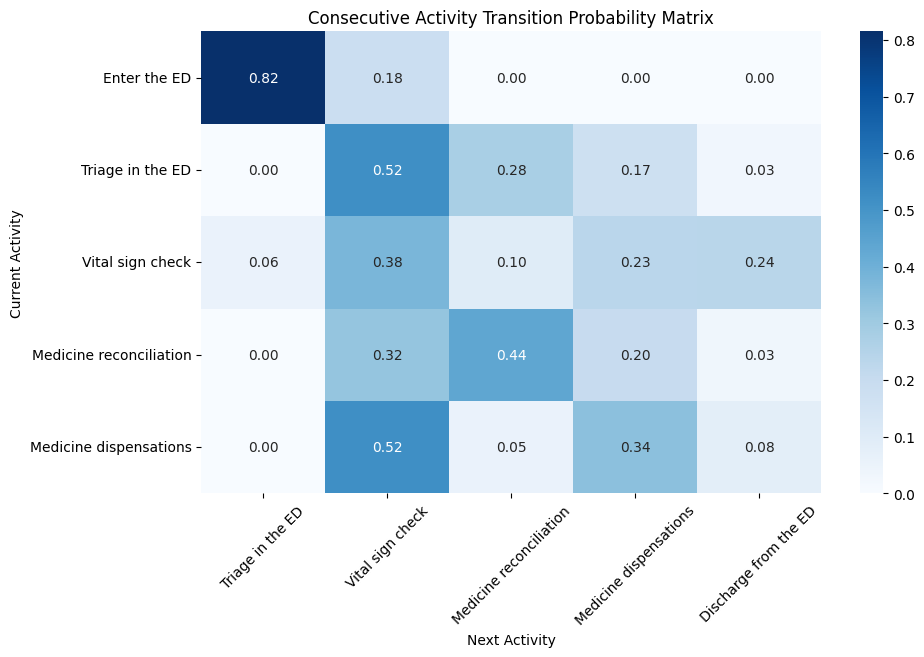

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(transition_probs, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Next Activity", )    
plt.ylabel("Current Activity" , ) 
plt.xticks(rotation = 45)
plt.title("Consecutive Activity Transition Probability Matrix")
plt.show()

# Inter Event Analysis

This matrix visualizes the average time elapsed between consecutive emergency department (ED) activities for all patient stays. Each cell represents the mean time (in minutes) it takes to transition from one activity (row) to the next (column).

By examining these transition times, we can understand the temporal flow of care in the ED — how quickly different stages typically follow one another. For example:

- Short intervals (lighter cells) indicate closely sequenced actions, such as Medicine reconciliation → Vital sign check.

- Longer intervals (darker cells) reveal bottlenecks or delays in the workflow, such as Triage in the ED → Discharge from the ED.

In [18]:
df_with_next_step.head(2)

,stay_id,subject_id,hadm_id,timestamps,activity,gender,race,arrival_transport,disposition,seq_num,icd_code,icd_version,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,rhythm,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn,name,icd_title,activity_rank,next_activity,next_activity_time,inter_activity_time
163792,30073413,10232160,26884134,2143-01-26 13:30:00,Enter the ED,F,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,AMBULANCE,None,<NA>,None,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None],0,Triage in the ED,2143-01-26 13:30:01,0 days 00:00:01
163793,30073413,10232160,26884134,2143-01-26 13:30:01,Triage in the ED,None,None,None,None,<NA>,None,<NA>,98.2,61.0,16.0,100.0,110.0,64.0,0,2.0,SI,None,None,None,<NA>,None,None,<NA>,<NA>,[None],[None],1,Vital sign check,2143-01-26 13:32:00,0 days 00:01:59


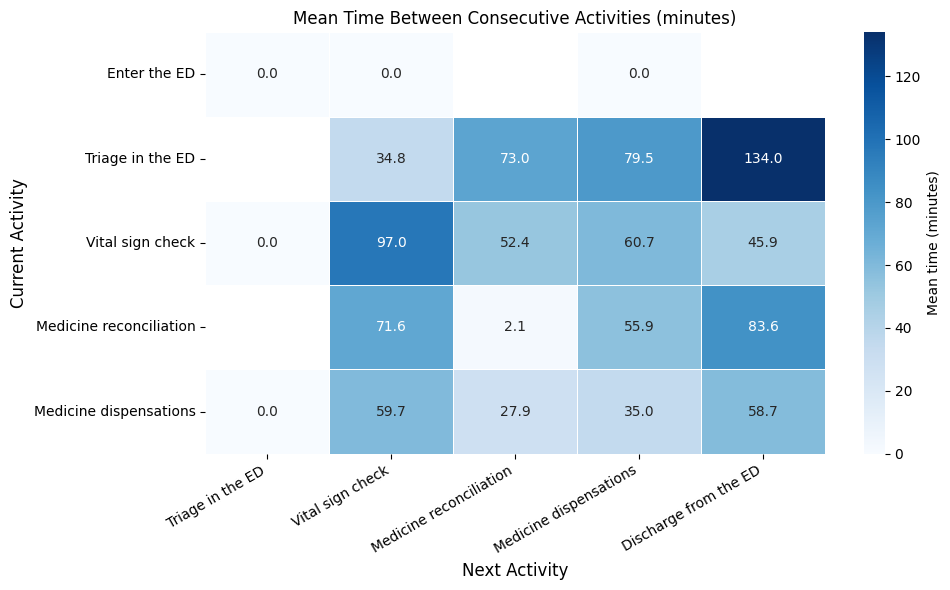

In [19]:
# Compute mean transition times
# Convert timedelta to minutes
df_with_next_step['inter_activity_time_mins'] = df_with_next_step['inter_activity_time'].dt.total_seconds() / 60

# Compute mean transition times in minutes
transition_time_matrix = (
    df_with_next_step.groupby(['activity', 'next_activity'])['inter_activity_time_mins']
    .mean()
    .unstack()
)


activity_order = [
    "Enter the ED",
    "Triage in the ED",
    "Vital sign check",
    "Medicine reconciliation",
    "Medicine dispensations",
]
next_activity_order = [
    "Triage in the ED",
    "Vital sign check",
    "Medicine reconciliation",
    "Medicine dispensations",
    "Discharge from the ED"
]

transition_time_matrix = transition_time_matrix.reindex(index=activity_order, columns=next_activity_order)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    transition_time_matrix,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Mean time (minutes)'}
)
plt.title("Mean Time Between Consecutive Activities (minutes)")
plt.xlabel("Next Activity", fontsize=12)
plt.ylabel("Current Activity", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()